## Training a convnet from scratch with training sample of 5000, a validation sample of 500, and a test sample of 500

### Downloading the data

In [1]:
!unzip -qq '/fs/ess/PGS0333/BA_64061_KSU/data/dogs-vs-cats.zip'

In [2]:
!unzip -qq train.zip

**Copying images to training, validation, and test directories**

In [3]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=5000)
make_subset("validation", start_index=5000, end_index=5500)
make_subset("test", start_index=5500, end_index=6000)

### Building the model

**Instantiating a small convnet for dogs vs. cats classification**

In [4]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 128)       73856 

**Configuring the model for training**

In [6]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

### Data preprocessing

**Using `image_dataset_from_directory` to read images**

In [7]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 10000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [8]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [9]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [10]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [11]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


**Displaying the shapes of the data and labels yielded by the `Dataset`**

In [12]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


**Fitting the model using a `Dataset`**

In [13]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
313/313 [==============================] - 13s 25ms/step - loss: 0.7100 - accuracy: 0.5490 - val_loss: 0.6479 - val_accuracy: 0.6480
Epoch 2/30
313/313 [==============================] - 7s 22ms/step - loss: 0.6220 - accuracy: 0.6644 - val_loss: 0.5241 - val_accuracy: 0.7440
Epoch 3/30
313/313 [==============================] - 7s 22ms/step - loss: 0.5212 - accuracy: 0.7444 - val_loss: 0.4661 - val_accuracy: 0.7810
Epoch 4/30
313/313 [==============================] - 7s 22ms/step - loss: 0.4452 - accuracy: 0.7956 - val_loss: 0.4746 - val_accuracy: 0.7870
Epoch 5/30
313/313 [==============================] - 7s 23ms/step - loss: 0.3822 - accuracy: 0.8326 - val_loss: 0.5290 - val_accuracy: 0.7740
Epoch 6/30
313/313 [==============================] - 7s 22ms/step - loss: 0.3272 - accuracy: 0.8573 - val_loss: 0.5761 - val_accuracy: 0.7860
Epoch 7/30
313/313 [==============================] - 7s 22ms/step - loss: 0.2765 - accuracy: 0.8835 - val_loss: 0.4929 - val_accuracy: 0.793

**Displaying curves of loss and accuracy during training**

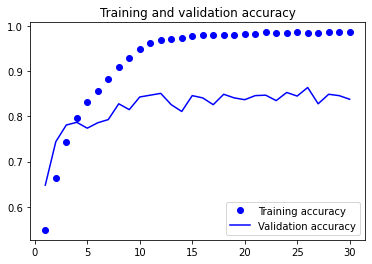

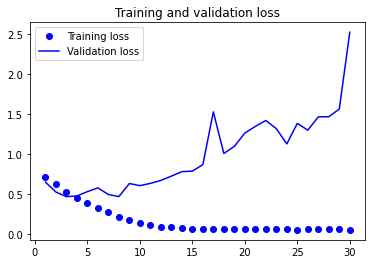

In [14]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [15]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 15ms/step - loss: 0.4459 - accuracy: 0.7990
Test accuracy: 0.799


### Using data augmentation

**Define a data augmentation stage to add to an image model**

In [16]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Displaying some randomly augmented training images**

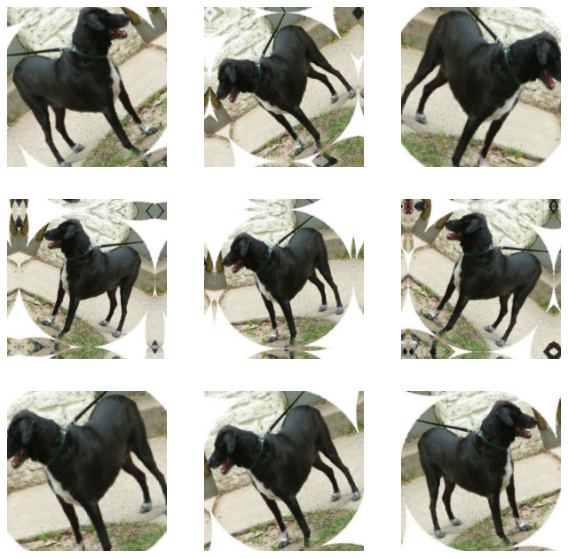

In [17]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Defining a new convnet that includes image augmentation, regularization and dropout**

In [18]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Training the regularized convnet**

In [19]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=80,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/80
313/313 [==============================] - 8s 23ms/step - loss: 0.7085 - accuracy: 0.5472 - val_loss: 0.6473 - val_accuracy: 0.6280
Epoch 2/80
313/313 [==============================] - 7s 23ms/step - loss: 0.6436 - accuracy: 0.6348 - val_loss: 0.5860 - val_accuracy: 0.6870
Epoch 3/80
313/313 [==============================] - 7s 23ms/step - loss: 0.6026 - accuracy: 0.6773 - val_loss: 0.5413 - val_accuracy: 0.7280
Epoch 4/80
313/313 [==============================] - 8s 25ms/step - loss: 0.5605 - accuracy: 0.7158 - val_loss: 0.6777 - val_accuracy: 0.6710
Epoch 5/80
313/313 [==============================] - 7s 23ms/step - loss: 0.5249 - accuracy: 0.7430 - val_loss: 0.5795 - val_accuracy: 0.7050
Epoch 6/80
313/313 [==============================] - 7s 23ms/step - loss: 0.4967 - accuracy: 0.7601 - val_loss: 0.4453 - val_accuracy: 0.7990
Epoch 7/80
313/313 [==============================] - 7s 23ms/step - loss: 0.4714 - accuracy: 0.7775 - val_loss: 0.4263 - val_accuracy: 0.8020

**Evaluating the model on the test set**

In [20]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 15ms/step - loss: 0.2071 - accuracy: 0.9150
Test accuracy: 0.915
